In [ ]:
import numpy as np
import pandas as pd

## Datos de entrenamiento
En el ficher `apple_news.csv` hay un listado de noticias desde el año `2012-07-01` hasta `2020-02-01`. Los datos tienen la siguiente estructura:

- _ticker_: Abreviatura del stock, en este caso **AAPL**
- _Date_: Fecha de la noticia
- _title_: Título de la noticia
- _content_: Contenido de la noticia
- _Open_: Precio de apertura de la acción ese día
- _Close_: Precio de cierre de la acción ese día
- _High_: Máximo precio alcanzado ese día
- _Low_: Mínimo precio alcanzado ese día
- _Volume_: Volumen de transacciones procesada ese día
- _label_: **0** si el precio subió o **1** si cayó o se mantuvo

Los demás datos no sabemos específicamente su significado o directamente no es relevante para nosotros.
Estos datos tienen algunos inconvenientes, por lo que tenemos que hacerle un preprocesamiento antes de continuar.

1. Las fechas están en formato `object`, por lo que hay que convertirlas a fechas para poder usarlas
2. Hay dias en donde no hay noticias y hay otros dias en donde hay mas de una noticia. Para esto lo que haremos será convinar todas las noticias del mismo día y convertirlas en una sola
3. Para los dias que no tiene noticias(ya veremos)

In [ ]:
import time
from google.colab import drive

drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/ML_Colab/apple_news.csv'
# Read the CSV file into a Pandas DataFrame
news_df = pd.read_csv(csv_file_path)
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df['Date'] = news_df['Date'].apply(lambda x: time.strftime('%Y-%m-%d', x.timetuple()))
# news_df.set_index('Date', inplace=True)

print('Shape: ', news_df.shape)
news_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (15975, 13)


Unnamed: 0 ticker        Date category  \
0           0   AAPL  2020-01-27  opinion   
1           1   AAPL  2020-01-27  opinion   
2           2   AAPL  2020-01-27  opinion   

                                               title  \
0  Apple Set To Beat Q1 Earnings Estimates  Tech ...   
1  Tech Daily  Intel Results  Netflix Surge  Appl...   
2  7 Monster Stock Market Predictions For The Wee...   

                                             content       Open       High  \
0  Technology giant Apple   NASDAQ AAPL   is set ...  77.514999  77.942497   
1  The top stories in this digest are Intel s   N...  77.514999  77.942497   
2  S P 500  SPY \nThis week will be packed with e...  77.514999  77.942497   

         Low      Close  Adj Close     Volume  label  
0  76.220001  77.237503  75.793358  161940000      0  
1  76.220001  77.237503  75.793358  161940000      0  
2  76.220001  77.237503  75.793358  161940000      0

# Analisis de los datos
 Utilizando dew_df.info() podemos ver que no hay valores nulos en las filas del dataset po rlo que no hay valores faltantes
 Las columnas title content ticker y categorie tienen tipo object ; el dataset tiene una combinacion de variables de tipo numericas y categoricas
 tiene una variable Unamed que es el id del elemento , lo que puede generar ruido al entrenar el modelo,


In [ ]:
amount_dates = news_df.index.unique()

print('Información básica sobre las noticias: ')
print(f'\tCantidad de noticias: {news_df.shape[0]}')
print(f'\tCantidad de fechas con noticias: {len(amount_dates)}')
print(f'\tNoticias sobrantes: {news_df.shape[0] - len(amount_dates)}')

Información básica sobre las noticias: 
	Cantidad de noticias: 15975
	Cantidad de fechas con noticias: 15975
	Noticias sobrantes: 0


Clasifiquemos todas los titulos de las noticias en positivas o negativas
- positive: 1
- negative: 0

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
def classify_text(text):
  inputs = tokenizer(text, return_tensors="pt")
  with torch.no_grad():
      logits = model(**inputs).logits
  predicted_class_id = logits.argmax().item()

  # get the score for each clasification
  scores = torch.nn.functional.softmax(logits, dim=1).tolist()[0]
  return {
      model.config.id2label[i]: score
      for i, score in enumerate(scores)
  }

classify_text("I hate you")

{'NEGATIVE': 0.9991129040718079, 'POSITIVE': 0.0008870704914443195}

In [ ]:
total_rows = news_df.shape[0]
for i in range(0, total_rows):
  x = classify_text(news_df['title'][i])
  print(f'Row: {i}/{total_rows} \t\t Classification: {x}')
  news_df.loc[i, 'NEGATIVE'] = x['NEGATIVE']
  news_df.loc[i, 'POSITIVE'] = x['POSITIVE']

Streaming output truncated to the last 5000 lines.
Row: 10975/15975 		 Classification: {'NEGATIVE': 0.984286904335022, 'POSITIVE': 0.015713071450591087}
Row: 10976/15975 		 Classification: {'NEGATIVE': 0.07026748359203339, 'POSITIVE': 0.9297325015068054}
Row: 10977/15975 		 Classification: {'NEGATIVE': 0.007236654404550791, 'POSITIVE': 0.992763340473175}
Row: 10978/15975 		 Classification: {'NEGATIVE': 0.006445057224482298, 'POSITIVE': 0.9935548901557922}
Row: 10979/15975 		 Classification: {'NEGATIVE': 0.9952502250671387, 'POSITIVE': 0.004749716725200415}
Row: 10980/15975 		 Classification: {'NEGATIVE': 0.04989830031991005, 'POSITIVE': 0.9501017332077026}
Row: 10981/15975 		 Classification: {'NEGATIVE': 0.008608737029135227, 'POSITIVE': 0.9913913011550903}
Row: 10982/15975 		 Classification: {'NEGATIVE': 0.035510722547769547, 'POSITIVE': 0.9644892811775208}
Row: 10983/15975 		 Classification: {'NEGATIVE': 0.9934989213943481, 'POSITIVE': 0.006501093972474337}
Row: 10984/15975 		 Classi

In [ ]:
news_df.to_csv('/content/drive/My Drive/ML_Colab/apple_news_classified.csv')
news_df.set_index('Date', inplace=True)
news_df

Unnamed: 0 ticker category  \
Date                                     
2020-01-27           0   AAPL  opinion   
2020-01-27           1   AAPL  opinion   
2020-01-27           2   AAPL  opinion   
2020-01-27           3   AAPL  opinion   
2020-01-27           4   AAPL  opinion   
...                ...    ...      ...   
2012-07-31       15970   AAPL  opinion   
2012-07-31       15971   AAPL  opinion   
2012-07-23       15972   AAPL  opinion   
2012-07-23       15973   AAPL  opinion   
2012-07-23       15974   AAPL  opinion   

                                                        title  \
Date                                                            
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   
2020-01-27  Tech Daily  Intel Results  Netflix Surge  Appl...   
2020-01-27  7 Monster Stock Market Predictions For The Wee...   
2020-01-27  Apple Earnings Preview  5G Launch  Expanding S...   
2020-01-27  Buy Surging Apple   Microsoft Stock Before Qua...   
...                                                       ...   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
2012-07-31  50 Stocks With The Best Dividend Growth In Jul...   
2012-07-23               Summer Heat Scorches Europe And U S    
2012-07-23     Apple Earnings Preview  Quarterly Dip On Deck    
2012-07-23                         Trade Apple After Earnings   

                                                      content       Open  \
Date                                                                       
2020-01-27  Technology giant Apple   NASDAQ AAPL   is set ...  77.514999   
2020-01-27  The top stories in this digest are Intel s   N...  77.514999   
2020-01-27  S P 500  SPY \nThis week will be packed with e...  77.514999   
2020-01-27    Reports Q1 2020 results on Tuesday  Jan  28 ...  77.514999   
2020-01-27  On today s episode of Full Court Finance here ...  77.514999   
...                                                       ...        ...   
2012-07-31  In the preceding posts  I examined the first t...  21.543928   
2012-07-31  Here is a current sheet of companies with fast...  21.543928   
2012-07-23  Europe flares as summer heat continues  Summer...  21.228571   
2012-07-23  Last quarter Apple  AAPL  reported the 2nd bes...  21.228571   
2012-07-23  It may look like a spider web  but the mishmas...  21.228571   

                 High        Low      Close  Adj Close     Volume  label  \
Date                                                                       
2020-01-27  77.942497  76.220001  77.237503  75.793358  161940000      0   
2020-01-27  77.942497  76.220001  77.237503  75.793358  161940000      0   
2020-01-27  77.942497  76.220001  77.237503  75.793358  161940000      0   
2020-01-27  77.942497  76.220001  77.237503  75.793358  161940000      0   
2020-01-27  77.942497  76.220001  77.237503  75.793358  161940000      0   
...               ...        ...        ...        ...        ...    ...   
2012-07-31  21.846430  21.525715  21.812857  18.624512  462327600      1   
2012-07-31  21.846430  21.525715  21.812857  18.624512  462327600      1   
2012-07-23  21.639286  20.989643  21.565357  18.413187  487975600      1   
2012-07-23  21.639286  20.989643  21.565357  18.413187  487975600      1   
2012-07-23  21.639286  20.989643  21.565357  18.413187  487975600      1   

            NEGATIVE  POSITIVE  
Date                            
2020-01-27  0.881650  0.118350  
2020-01-27  0.349483  0.650517  
2020-01-27  0.995007  0.004993  
2020-01-27  0.001392  0.998608  
2020-01-27  0.965802  0.034198  
...              ...       ...  
2012-07-31  0.026508  0.973492  
2012-07-31  0.000801  0.999199  
2012-07-23  0.008338  0.991662  
2012-07-23  0.743017  0.256983  
2012-07-23  0.936430  0.063570  

[15975 rows x 14 columns]

Eliminación de todas las noticias que habían el mismo día y convertirlas todas a una única noticia por día

In [ ]:
news_df = news_df.sort_values(by='Date', ascending=False)
news_df['new'] = news_df['title'] + ' ' + news_df['content']
news_df = news_df.groupby('Date').agg({
    'new': ' '.join,
    'title': ' '.join,
    'content': ' '.join,
    'POSITIVE': 'sum',
    'NEGATIVE': 'sum'
}).reset_index()
news_df.set_index('Date', inplace=True)
# Display the combined news DataFrame
print('New Shape: ', news_df.shape)
news_df

New Shape:  (1654, 5)


new  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Europe fl...   
2012-07-24  Market Bait And Switch That is the sound we ar...   
2012-07-27  Will AAPL Fall From The Tree   Apple s  AAPL  ...   
2012-07-30  Bulls Snatch Victory From Jaws of Defeat Last ...   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
...                                                       ...   
2020-01-21  Honda to join White House initiative to boost ...   
2020-01-22  How Services Will Become Apple s Next  100 Bil...   
2020-01-23  Broadcom  Deals with Apple could be worth  15 ...   
2020-01-24  Need to Know  Apple shares are bound for  400 ...   
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   

                                                        title  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Apple Ear...   
2012-07-24                             Market Bait And Switch   
2012-07-27                     Will AAPL Fall From The Tree     
2012-07-30           Bulls Snatch Victory From Jaws of Defeat   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
...                                                       ...   
2020-01-21  Honda to join White House initiative to boost ...   
2020-01-22  How Services Will Become Apple s Next  100 Bil...   
2020-01-23  Broadcom  Deals with Apple could be worth  15 ...   
2020-01-24  Need to Know  Apple shares are bound for  400 ...   
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   

                                                      content   POSITIVE  \
Date                                                                       
2012-07-23  Europe flares as summer heat continues  Summer...   1.312215   
2012-07-24  That is the sound we are going to hear soon fr...   0.057011   
2012-07-27  Apple s  AAPL  sales for the third quarter mis...   0.000834   
2012-07-30  Last week  the bulls pulled another save out o...   0.252697   
2012-07-31  In the preceding posts  I examined the first t...   1.972691   
...                                                       ...        ...   
2020-01-21  By David Shepardson\nWASHINGTON  Reuters    Ho...  15.215485   
2020-01-22  There has been no greater growth story in the ...  13.098037   
2020-01-23  Broadcom Inc  \r\n\r\n                        ...  11.316891   
2020-01-24  A week that started with a coronavirus panic l...   8.038409   
2020-01-27  Technology giant Apple   NASDAQ AAPL   is set ...   2.793224   

             NEGATIVE  
Date                   
2012-07-23   1.687785  
2012-07-24   0.942989  
2012-07-27   0.999166  
2012-07-30   0.747303  
2012-07-31   0.027309  
...               ...  
2020-01-21  15.784515  
2020-01-22  16.901963  
2020-01-23  12.683109  
2020-01-24   7.961590  
2020-01-27   5.206776  

[1654 rows x 5 columns]

## Obtenemos un dataset limpio de noticias procesadas


### Procesar la noticias con nlp

Pasamos de tener `15975` noticias a solo quedarnos con `1654`. Ahora vectoricemos las noticias utilizando técnicas de nlp.

In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
  return tokens

news_df['processed'] = news_df['new'].apply(preprocess)
news_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


new  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Europe fl...   
2012-07-24  Market Bait And Switch That is the sound we ar...   
2012-07-27  Will AAPL Fall From The Tree   Apple s  AAPL  ...   
2012-07-30  Bulls Snatch Victory From Jaws of Defeat Last ...   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
...                                                       ...   
2020-01-21  Honda to join White House initiative to boost ...   
2020-01-22  How Services Will Become Apple s Next  100 Bil...   
2020-01-23  Broadcom  Deals with Apple could be worth  15 ...   
2020-01-24  Need to Know  Apple shares are bound for  400 ...   
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   

                                                        title  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Apple Ear...   
2012-07-24                             Market Bait And Switch   
2012-07-27                     Will AAPL Fall From The Tree     
2012-07-30           Bulls Snatch Victory From Jaws of Defeat   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
...                                                       ...   
2020-01-21  Honda to join White House initiative to boost ...   
2020-01-22  How Services Will Become Apple s Next  100 Bil...   
2020-01-23  Broadcom  Deals with Apple could be worth  15 ...   
2020-01-24  Need to Know  Apple shares are bound for  400 ...   
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   

                                                      content   POSITIVE  \
Date                                                                       
2012-07-23  Europe flares as summer heat continues  Summer...   1.312215   
2012-07-24  That is the sound we are going to hear soon fr...   0.057011   
2012-07-27  Apple s  AAPL  sales for the third quarter mis...   0.000834   
2012-07-30  Last week  the bulls pulled another save out o...   0.252697   
2012-07-31  In the preceding posts  I examined the first t...   1.972691   
...                                                       ...        ...   
2020-01-21  By David Shepardson\nWASHINGTON  Reuters    Ho...  15.215485   
2020-01-22  There has been no greater growth story in the ...  13.098037   
2020-01-23  Broadcom Inc  \r\n\r\n                        ...  11.316891   
2020-01-24  A week that started with a coronavirus panic l...   8.038409   
2020-01-27  Technology giant Apple   NASDAQ AAPL   is set ...   2.793224   

             NEGATIVE                                          processed  
Date                                                                      
2012-07-23   1.687785  [summer, heat, scorches, europe, u, europe, fl...  
2012-07-24   0.942989  [market, bait, switch, sound, going, hear, soo...  
2012-07-27   0.999166  [aapl, fall, tree, apple, aapl, sales, third, ...  
2012-07-30   0.747303  [bulls, snatch, victory, jaws, defeat, last, w...  
2012-07-31   0.027309  [driving, china, real, estate, rally, part, 3,...  
...               ...                                                ...  
2020-01-21  15.784515  [honda, join, white, house, initiative, boost,...  
2020-01-22  16.901963  [services, become, apple, next, 100, billion, ...  
2020-01-23  12.683109  [broadcom, deals, apple, could, worth, 15, bil...  
2020-01-24   7.961590  [need, know, apple, shares, bound, 400, says, ...  
2020-01-27   5.206776  [apple, set, beat, q1, earnings, estimates, te...  

[1654 rows x 6 columns]

In [ ]:
# Entrenar el modelo de Word2Vec
model = Word2Vec(
  sentences=news_df['processed'],
  vector_size=100,
  window=5,
  min_count=1,
  workers=40
)

In [ ]:
# Función para obtener el embedding promedio de una noticia
def get_average_embedding(tokens, model):
  # Filtrar tokens que están en el vocabulario del modelo
  tokens = [token for token in tokens if token in model.wv]
  if len(tokens) == 0:
    return np.zeros(model.vector_size)
  # Calcular el embedding promedio
  embeddings = [model.wv[token] for token in tokens]
  average_embedding = np.mean(embeddings, axis=0)
  return average_embedding

# Obtener embeddings promedio para cada noticia
news_df['embedding'] = news_df['processed'].apply(lambda tokens: get_average_embedding(tokens, model))
news_df

new  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Europe fl...   
2012-07-24  Market Bait And Switch That is the sound we ar...   
2012-07-27  Will AAPL Fall From The Tree   Apple s  AAPL  ...   
2012-07-30  Bulls Snatch Victory From Jaws of Defeat Last ...   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
...                                                       ...   
2020-01-21  Honda to join White House initiative to boost ...   
2020-01-22  How Services Will Become Apple s Next  100 Bil...   
2020-01-23  Broadcom  Deals with Apple could be worth  15 ...   
2020-01-24  Need to Know  Apple shares are bound for  400 ...   
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   

                                                        title  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Apple Ear...   
2012-07-24                             Market Bait And Switch   
2012-07-27                     Will AAPL Fall From The Tree     
2012-07-30           Bulls Snatch Victory From Jaws of Defeat   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
...                                                       ...   
2020-01-21  Honda to join White House initiative to boost ...   
2020-01-22  How Services Will Become Apple s Next  100 Bil...   
2020-01-23  Broadcom  Deals with Apple could be worth  15 ...   
2020-01-24  Need to Know  Apple shares are bound for  400 ...   
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   

                                                      content   POSITIVE  \
Date                                                                       
2012-07-23  Europe flares as summer heat continues  Summer...   1.312215   
2012-07-24  That is the sound we are going to hear soon fr...   0.057011   
2012-07-27  Apple s  AAPL  sales for the third quarter mis...   0.000834   
2012-07-30  Last week  the bulls pulled another save out o...   0.252697   
2012-07-31  In the preceding posts  I examined the first t...   1.972691   
...                                                       ...        ...   
2020-01-21  By David Shepardson\nWASHINGTON  Reuters    Ho...  15.215485   
2020-01-22  There has been no greater growth story in the ...  13.098037   
2020-01-23  Broadcom Inc  \r\n\r\n                        ...  11.316891   
2020-01-24  A week that started with a coronavirus panic l...   8.038409   
2020-01-27  Technology giant Apple   NASDAQ AAPL   is set ...   2.793224   

             NEGATIVE                                          processed  \
Date                                                                       
2012-07-23   1.687785  [summer, heat, scorches, europe, u, europe, fl...   
2012-07-24   0.942989  [market, bait, switch, sound, going, hear, soo...   
2012-07-27   0.999166  [aapl, fall, tree, apple, aapl, sales, third, ...   
2012-07-30   0.747303  [bulls, snatch, victory, jaws, defeat, last, w...   
2012-07-31   0.027309  [driving, china, real, estate, rally, part, 3,...   
...               ...                                                ...   
2020-01-21  15.784515  [honda, join, white, house, initiative, boost,...   
2020-01-22  16.901963  [services, become, apple, next, 100, billion, ...   
2020-01-23  12.683109  [broadcom, deals, apple, could, worth, 15, bil...   
2020-01-24   7.961590  [need, know, apple, shares, bound, 400, says, ...   
2020-01-27   5.206776  [apple, set, beat, q1, earnings, estimates, te...   

                                                    embedding  
Date                                                           
2012-07-23  [0.05905736, 0.78830993, 0.06396842, 0.13975, ...  
2012-07-24  [0.37770188, 0.25995106, 0.2782316, -0.3666865...  
2012-07-27  [-0.34234846, 0.27494824, 0.10981934, -0.38767...  
2012-07-30  [0.110929586, 0.7759576, 0.13119523, -0.122955...  
2012

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


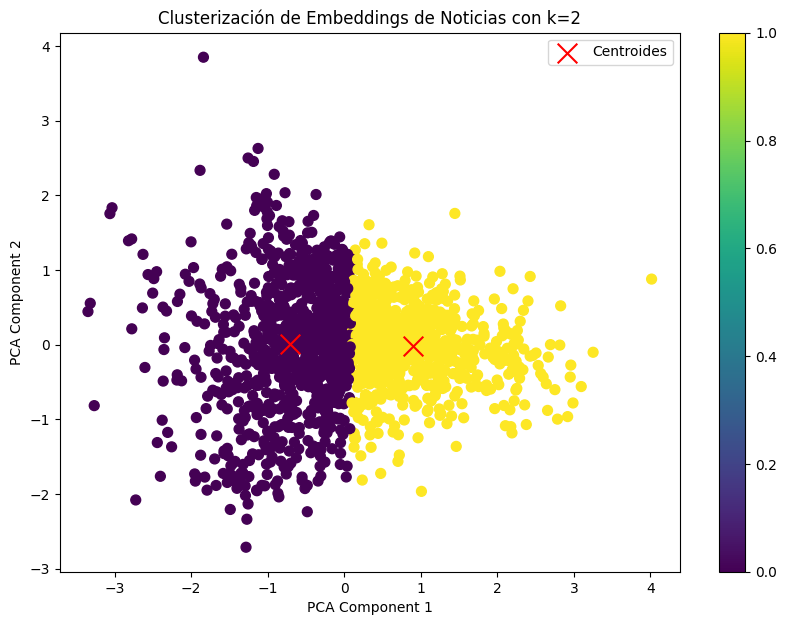

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


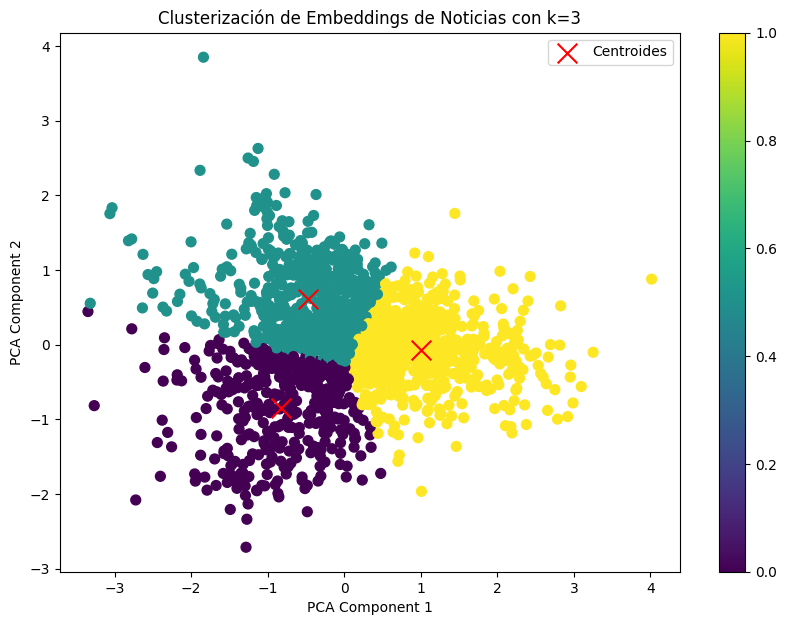

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


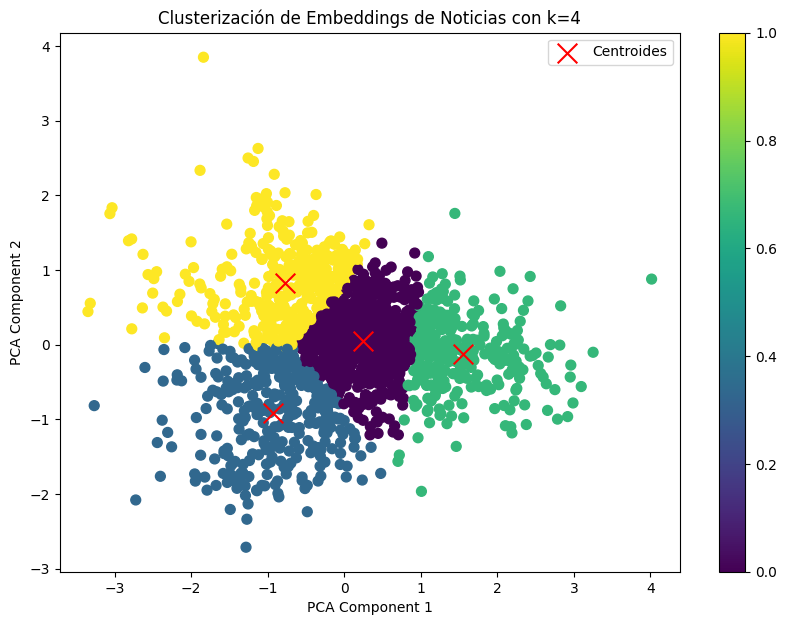

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


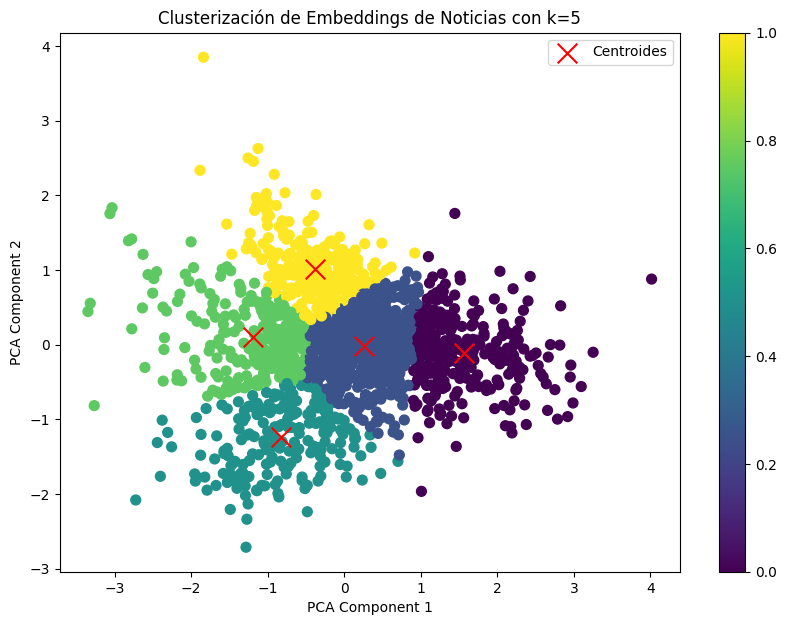

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


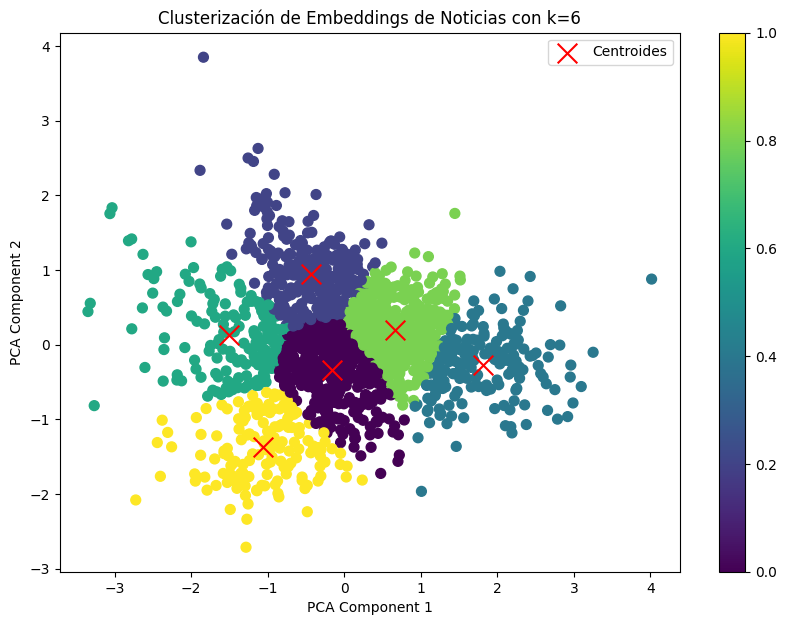

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


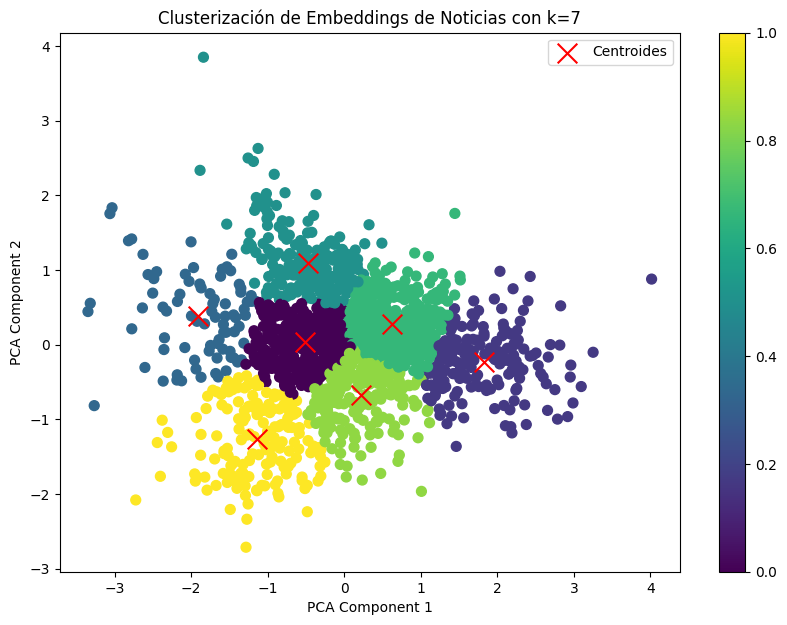

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


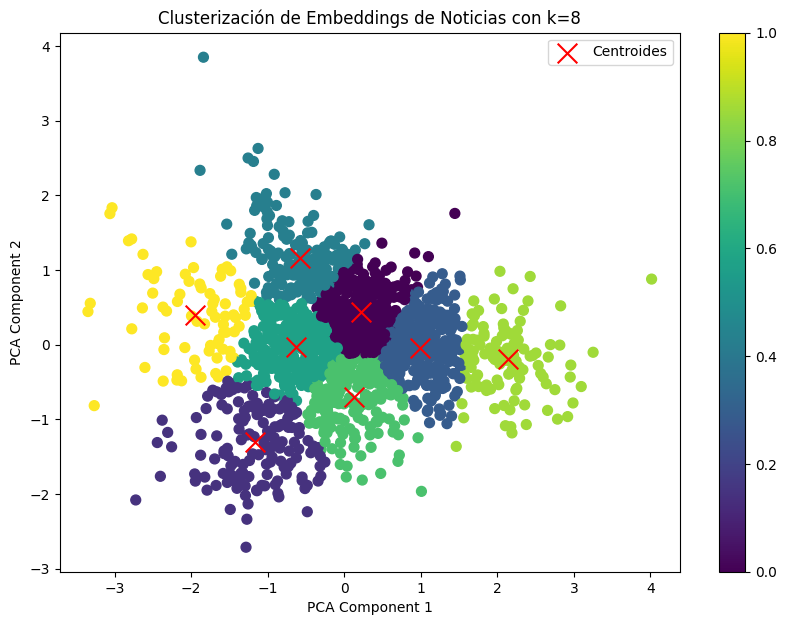

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


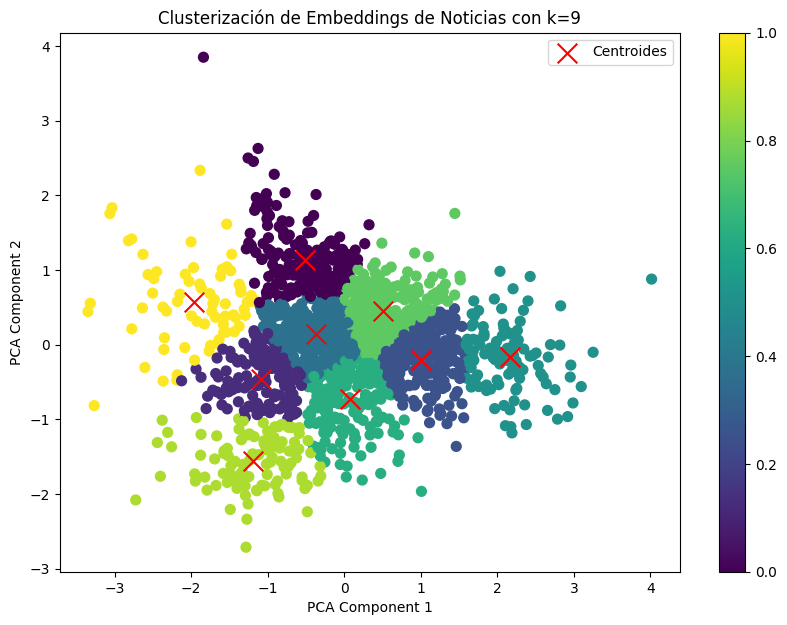

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


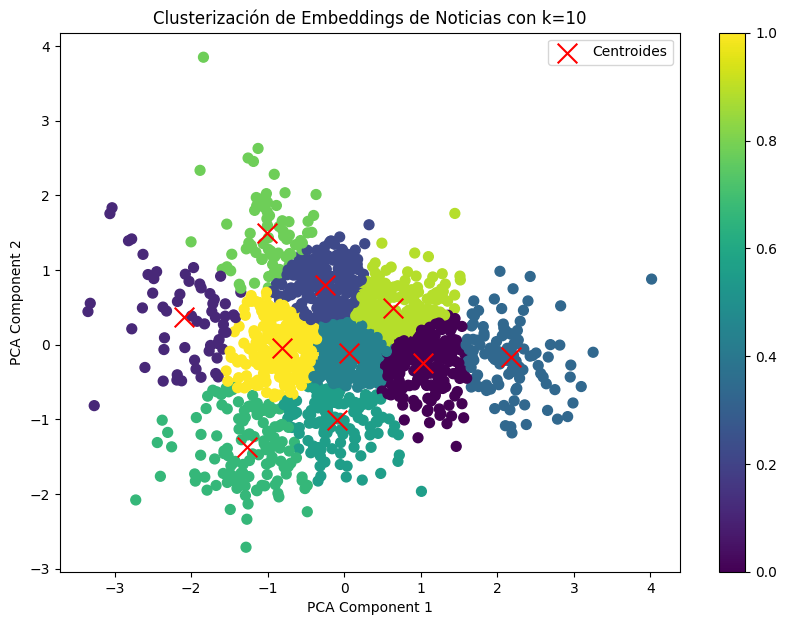

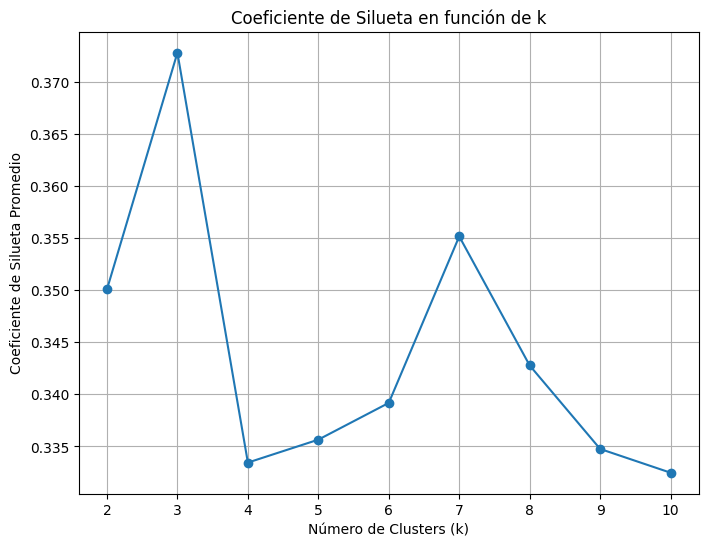

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Convertir la columna de embeddings a una matriz 2D (cada fila es un embedding)
embeddings = np.vstack(news_df['embedding'])

# Reducir la dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Lista de valores de k que deseas probar
k_values = range(2, 11)  # Probamos desde 2 hasta 10 clusters

# Listas para almacenar las métricas de evaluación
silhouette_avg_scores = []

# Iterar sobre diferentes valores de k
for k in k_values:
    # Aplicar KMeans para clusterizar los embeddings
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(reduced_embeddings)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(reduced_embeddings, clusters)
    silhouette_avg_scores.append(silhouette_avg)

    # Obtener el coeficiente de silueta para cada punto de datos
    silhouette_values = silhouette_samples(reduced_embeddings, clusters)

    # Visualizar los clusters y sus centroides en el espacio PCA reducido
    plt.figure(figsize=(10, 7))

    # Scatter plot de los puntos de datos coloreados por cluster
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=50)

    # Plot de los centroides de cada cluster
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=200, label='Centroides')

    plt.title(f'Clusterización de Embeddings de Noticias con k={k}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.colorbar()
    plt.show()

# Graficar el coeficiente de silueta en función de k
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_avg_scores, marker='o')
plt.title('Coeficiente de Silueta en función de k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.xticks(k_values)
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

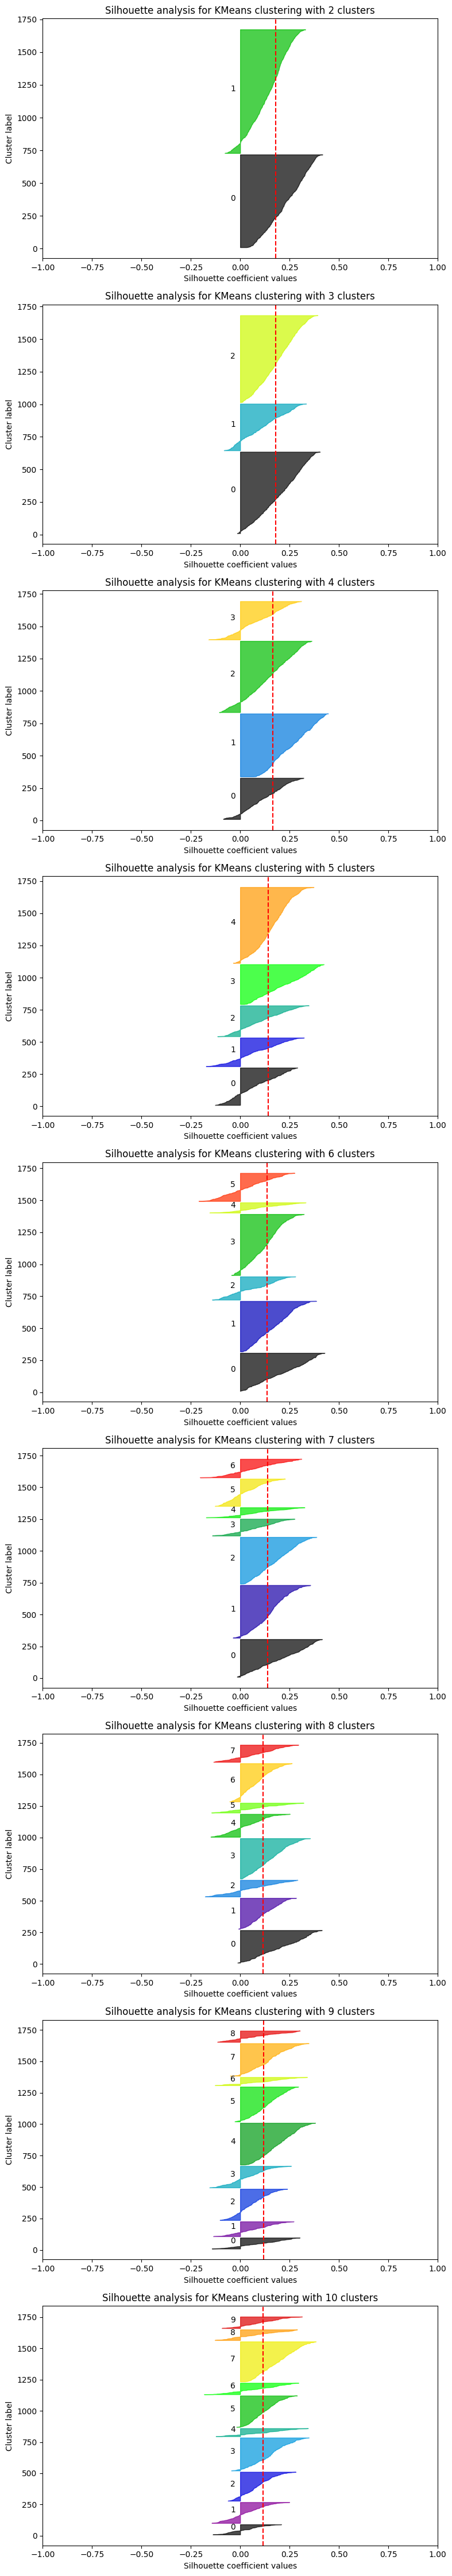

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Convertir la columna de embeddings a una matriz 2D (cada fila es un embedding)
embeddings = np.vstack(news_df['embedding'])

# Lista de valores de k que deseas probar
range_n_clusters = range(2, 11)  # Probamos desde 2 hasta 10 clusters

# Configurar la figura para los gráficos
plt.figure(figsize=(15, len(range_n_clusters) * 5))

for i, n_clusters in enumerate(range_n_clusters, start=1):
    # Aplicar KMeans para clusterizar los embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(embeddings)

    # Calcular métricas de evaluación
    silhouette_avg = silhouette_score(embeddings, clusters)
    sample_silhouette_values = silhouette_samples(embeddings, clusters)

    # Configurar el gráfico de Silhouette
    plt.subplot(len(range_n_clusters), 2, 2*i - 1)

    # Configurar el gráfico de Silhouette para cada muestra
    plt.title('Silhouette analysis for KMeans clustering with {} clusters'.format(n_clusters))
    plt.xlabel('Silhouette coefficient values')
    plt.ylabel('Cluster label')

    y_lower = 10
    for j in range(n_clusters):
        jth_cluster_silhouette_values = sample_silhouette_values[clusters == j]
        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, jth_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    # Trazar el coeficiente de silueta promedio y una línea vertical para indicarlo
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.xlim([-1, 1])

plt.tight_layout()
plt.show()




In [ ]:
news_df.head(1)

new  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Europe fl...   

                                                        title  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Apple Ear...   

                                                      content  POSITIVE  \
Date                                                                      
2012-07-23  Europe flares as summer heat continues  Summer...  1.312215   

            NEGATIVE                                          processed  \
Date                                                                      
2012-07-23  1.687785  [summer, heat, scorches, europe, u, europe, fl...   

                                                    embedding  
Date                                                           
2012-07-23  [0.05905736, 0.78830993, 0.06396842, 0.13975, ...

In [ ]:
# eliminando columnas innecesarias
news_df.drop(columns=['new', 'processed'], inplace=True)

In [ ]:
news_df.head(1)

title  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Apple Ear...   

                                                      content  POSITIVE  \
Date                                                                      
2012-07-23  Europe flares as summer heat continues  Summer...  1.312215   

            NEGATIVE                                          embedding  
Date                                                                     
2012-07-23  1.687785  [0.05905736, 0.78830993, 0.06396842, 0.13975, ...

# PROCESAMIENTO DEL CSV DEL PRECIO DEL STOCK

In [ ]:
import pandas as pd
import time
from google.colab import drive

drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/ML_Colab/apple_stock_prices.csv'
# Read the CSV file into a Pandas DataFrame
prices_df = pd.read_csv(csv_file_path)
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df['Date'] = prices_df['Date'].apply(lambda x: time.strftime('%Y-%m-%d', x.timetuple()))
prices_df.set_index('Date', inplace=True)

print('Shape: ', prices_df.shape)
prices_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
prices_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (6165, 7)


Open        High         Low       Close     Volume
Date                                                                 
2000-01-03    0.791669    0.849227    0.767607    0.844981  535796800
2000-01-04    0.817145    0.835073    0.763833    0.773740  512377600
2000-01-05    0.783176    0.834601    0.777515    0.785063  778321600
2000-01-06    0.801105    0.807709    0.717125    0.717125  767972800
2000-01-07    0.728448    0.762417    0.720900    0.751094  460734400
...                ...         ...         ...         ...        ...
2024-06-28  215.770004  216.070007  210.300003  210.619995   82542700
2024-07-01  212.089996  217.509995  211.919998  216.750000   60402900
2024-07-02  216.149994  220.380005  215.100006  220.270004   58046200
2024-07-03  220.000000  221.550003  219.029999  221.550003   37369800
2024-07-05  221.649994  226.449997  221.649994  226.339996   58797569

[6165 rows x 5 columns]

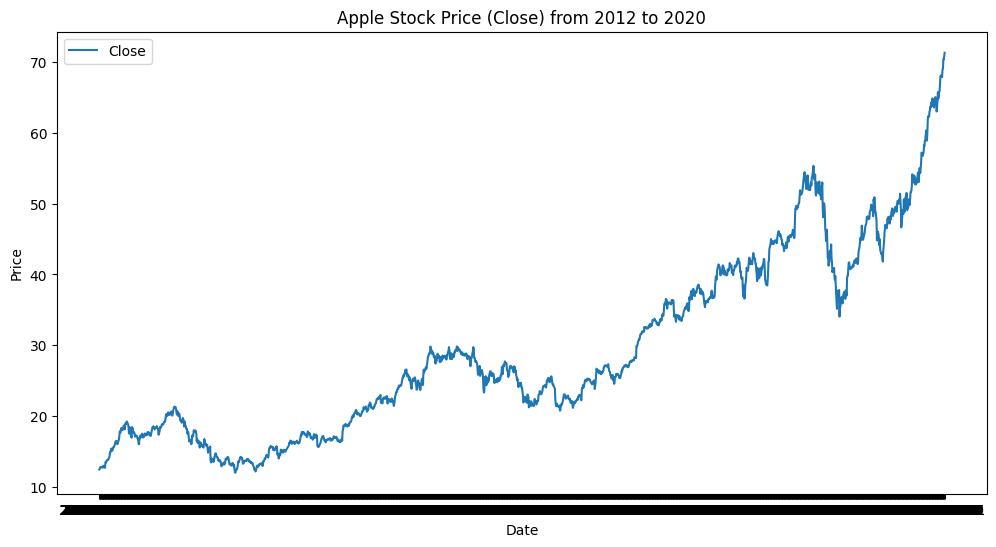

In [ ]:
import matplotlib.pyplot as plt

# Select the data from 2017 to 2024
prices_df_subset = prices_df["2012":"2020"]

# Plot the close prices
plt.figure(figsize=(12, 6))
plt.plot(prices_df_subset["Close"], label="Close")
plt.title("Apple Stock Price (Close) from 2012 to 2020")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


El histórico de datos tiene el precio durante varios años atrás pero no tiene datos los fines de semana debido a que la bolsa de valores no está abierta esos días. Lo que haremos entonces será insertar nuevos datos en esos fines de semanas y mantener el mismo precio del día anterior ya que no hubo operaciones y el volumen ponerlo en cero

In [ ]:
# Comprobar la cantidad de fechas que tienen noticias pero que no tienen precio
missing_dates = set(news_df.index) - set(prices_df.index)
print(f"Number of dates in news_df that are not in prices_df: {len(missing_dates)}")
missing_dates

Number of dates in news_df that are not in prices_df: 123


{'2012-11-10',
 '2012-12-09',
 '2013-02-10',
 '2013-05-12',
 '2013-06-02',
 '2013-08-04',
 '2013-08-11',
 '2013-10-06',
 '2013-11-09',
 '2013-12-08',
 '2014-01-04',
 '2014-01-05',
 '2014-01-12',
 '2014-02-09',
 '2014-05-11',
 '2014-06-01',
 '2014-06-08',
 '2014-07-04',
 '2014-09-01',
 '2014-09-07',
 '2014-10-12',
 '2014-11-02',
 '2014-11-08',
 '2014-11-09',
 '2015-01-04',
 '2015-02-01',
 '2015-02-07',
 '2015-03-08',
 '2015-04-03',
 '2015-04-05',
 '2015-04-11',
 '2015-04-12',
 '2015-05-03',
 '2015-05-10',
 '2015-06-07',
 '2015-07-05',
 '2015-07-12',
 '2015-08-09',
 '2015-09-06',
 '2015-10-04',
 '2015-10-11',
 '2015-11-08',
 '2015-12-06',
 '2016-01-03',
 '2016-02-06',
 '2016-03-05',
 '2016-04-02',
 '2016-04-03',
 '2016-04-10',
 '2016-05-01',
 '2016-05-08',
 '2016-06-05',
 '2016-06-12',
 '2016-07-03',
 '2016-07-04',
 '2016-07-10',
 '2016-08-07',
 '2016-09-03',
 '2016-09-05',
 '2016-09-11',
 '2016-10-02',
 '2017-01-02',
 '2017-01-08',
 '2017-02-05',
 '2017-03-05',
 '2017-04-08',
 '2017-05-

In [ ]:
# eliminar por ahora estos días de news_df
news_df.drop(missing_dates, inplace=True)
# Comprobar la cantidad de fechas que tienen noticias pero que no tienen precio
missing_dates = set(news_df.index) - set(prices_df.index)
print(f"Number of dates in news_df that are not in prices_df: {len(missing_dates)}")
missing_dates

Number of dates in news_df that are not in prices_df: 0


set()

In [ ]:
# combinar los dos dataframes por Date
merged_df = prices_df.combine_first(news_df)
merged_df

Close        High         Low  NEGATIVE        Open  \
Date                                                                   
2000-01-03    0.844981    0.849227    0.767607       NaN    0.791669   
2000-01-04    0.773740    0.835073    0.763833       NaN    0.817145   
2000-01-05    0.785063    0.834601    0.777515       NaN    0.783176   
2000-01-06    0.717125    0.807709    0.717125       NaN    0.801105   
2000-01-07    0.751094    0.762417    0.720900       NaN    0.728448   
...                ...         ...         ...       ...         ...   
2024-06-28  210.619995  216.070007  210.300003       NaN  215.770004   
2024-07-01  216.750000  217.509995  211.919998       NaN  212.089996   
2024-07-02  220.270004  220.380005  215.100006       NaN  216.149994   
2024-07-03  221.550003  221.550003  219.029999       NaN  220.000000   
2024-07-05  226.339996  226.449997  221.649994       NaN  221.649994   

            POSITIVE     Volume content embedding title  
Date                                                     
2000-01-03       NaN  535796800     NaN       NaN   NaN  
2000-01-04       NaN  512377600     NaN       NaN   NaN  
2000-01-05       NaN  778321600     NaN       NaN   NaN  
2000-01-06       NaN  767972800     NaN       NaN   NaN  
2000-01-07       NaN  460734400     NaN       NaN   NaN  
...              ...        ...     ...       ...   ...  
2024-06-28       NaN   82542700     NaN       NaN   NaN  
2024-07-01       NaN   60402900     NaN       NaN   NaN  
2024-07-02       NaN   58046200     NaN       NaN   NaN  
2024-07-03       NaN   37369800     NaN       NaN   NaN  
2024-07-05       NaN   58797569     NaN       NaN   NaN  

[6165 rows x 10 columns]

In [ ]:
embedding_size = news_df['embedding'][0].size
merged_df['embedding'] = merged_df['embedding'].apply(lambda x: np.zeros(embedding_size) if pd.isna(x) is True else x)
merged_df

Close        High         Low  NEGATIVE        Open  \
Date                                                                   
2000-01-03    0.844981    0.849227    0.767607       NaN    0.791669   
2000-01-04    0.773740    0.835073    0.763833       NaN    0.817145   
2000-01-05    0.785063    0.834601    0.777515       NaN    0.783176   
2000-01-06    0.717125    0.807709    0.717125       NaN    0.801105   
2000-01-07    0.751094    0.762417    0.720900       NaN    0.728448   
...                ...         ...         ...       ...         ...   
2024-06-28  210.619995  216.070007  210.300003       NaN  215.770004   
2024-07-01  216.750000  217.509995  211.919998       NaN  212.089996   
2024-07-02  220.270004  220.380005  215.100006       NaN  216.149994   
2024-07-03  221.550003  221.550003  219.029999       NaN  220.000000   
2024-07-05  226.339996  226.449997  221.649994       NaN  221.649994   

            POSITIVE     Volume content  \
Date                                      
2000-01-03       NaN  535796800     NaN   
2000-01-04       NaN  512377600     NaN   
2000-01-05       NaN  778321600     NaN   
2000-01-06       NaN  767972800     NaN   
2000-01-07       NaN  460734400     NaN   
...              ...        ...     ...   
2024-06-28       NaN   82542700     NaN   
2024-07-01       NaN   60402900     NaN   
2024-07-02       NaN   58046200     NaN   
2024-07-03       NaN   37369800     NaN   
2024-07-05       NaN   58797569     NaN   

                                                    embedding title  
Date                                                                 
2000-01-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2000-01-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2000-01-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2000-01-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2000-01-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
...                                                       ...   ...  
2024-06-28  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2024-07-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2024-07-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2024-07-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  
2024-07-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN  

[6165 rows x 10 columns]

### Datos extras que nos servirán
Ademas de tener el histórico de precios, el volumen manejado por cada día y el embedding de las noticias, es interesante añadir algunos indicadores técnicos que se usan para hacer análisis técnico en el trading y encontrar patrones. Estaremos usando 3 Indicadores:
1. EMA50 (Media movil exponencial de 50 periodos)
2. EMA200 (Media movil exponencial de 200 periodos)

In [ ]:
%%capture

# Primero, instalar las dependencias necesarias
!apt-get install -y libzzip-dev libcurl4-openssl-dev

# Descargar e instalar TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install

# Finalmente, instalar la librería de Python
!pip install TA-Lib

In [ ]:
# Calcular indicadores técnicos
import talib

# Media Móvil Simple (SMA)
merged_df['SMA_200'] = talib.SMA(merged_df['Close'], timeperiod=200)

# Media Móvil Exponencial (EMA)
merged_df['EMA_50'] = talib.EMA(merged_df['Close'], timeperiod=50)

# fill the first positions in SMA_200 and EMA_500 with zero
merged_df['SMA_200'] = merged_df['SMA_200'].fillna(method='bfill')
merged_df['EMA_50'] = merged_df['EMA_50'].fillna(method='bfill')

merged_df

Close        High         Low  NEGATIVE        Open  \
Date                                                                   
2000-01-03    0.844981    0.849227    0.767607       NaN    0.791669   
2000-01-04    0.773740    0.835073    0.763833       NaN    0.817145   
2000-01-05    0.785063    0.834601    0.777515       NaN    0.783176   
2000-01-06    0.717125    0.807709    0.717125       NaN    0.801105   
2000-01-07    0.751094    0.762417    0.720900       NaN    0.728448   
...                ...         ...         ...       ...         ...   
2024-06-28  210.619995  216.070007  210.300003       NaN  215.770004   
2024-07-01  216.750000  217.509995  211.919998       NaN  212.089996   
2024-07-02  220.270004  220.380005  215.100006       NaN  216.149994   
2024-07-03  221.550003  221.550003  219.029999       NaN  220.000000   
2024-07-05  226.339996  226.449997  221.649994       NaN  221.649994   

            POSITIVE     Volume content  \
Date                                      
2000-01-03       NaN  535796800     NaN   
2000-01-04       NaN  512377600     NaN   
2000-01-05       NaN  778321600     NaN   
2000-01-06       NaN  767972800     NaN   
2000-01-07       NaN  460734400     NaN   
...              ...        ...     ...   
2024-06-28       NaN   82542700     NaN   
2024-07-01       NaN   60402900     NaN   
2024-07-02       NaN   58046200     NaN   
2024-07-03       NaN   37369800     NaN   
2024-07-05       NaN   58797569     NaN   

                                                    embedding title  \
Date                                                                  
2000-01-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2000-01-04  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2000-01-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2000-01-06  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2000-01-07  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
...                                                       ...   ...   
2024-06-28  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2024-07-01  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2024-07-02  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2024-07-03  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   
2024-07-05  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   NaN   

               SMA_200      EMA_50  
Date                                
2000-01-03    0.799947    0.835547  
2000-01-04    0.799947    0.835547  
2000-01-05    0.799947    0.835547  
2000-01-06    0.799947    0.835547  
2000-01-07    0.799947    0.835547  
...                ...         ...  
2024-06-28  183.323794  195.344996  
2024-07-01  183.539925  196.184407  
2024-07-02  183.766037  197.128941  
2024-07-03  184.002184  198.086629  
2024-07-05  184.247539  199.194605  

[6165 rows x 12 columns]

In [ ]:
merged_df.to_csv('/content/drive/My Drive/ML_Colab/merged_apple_price_news.csv')

# Analisis exploratorio de datos
todos los datos son numericos y no hay datos faltantes


In [ ]:
import pandas as pd
import time
from google.colab import drive

drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/ML_Colab/apple_stock_prices.csv'
# Read the CSV file into a Pandas DataFrame
prices_df = pd.read_csv(csv_file_path)
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df['Date'] = prices_df['Date'].apply(lambda x: time.strftime('%Y-%m-%d', x.timetuple()))
prices_df.set_index('Date', inplace=True)

print('Shape: ', prices_df.shape)
prices_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (6165, 7)


Open        High         Low       Close     Volume  \
Date                                                                    
2000-01-03    0.791669    0.849227    0.767607    0.844981  535796800   
2000-01-04    0.817145    0.835073    0.763833    0.773740  512377600   
2000-01-05    0.783176    0.834601    0.777515    0.785063  778321600   
2000-01-06    0.801105    0.807709    0.717125    0.717125  767972800   
2000-01-07    0.728448    0.762417    0.720900    0.751094  460734400   
...                ...         ...         ...         ...        ...   
2024-06-28  215.770004  216.070007  210.300003  210.619995   82542700   
2024-07-01  212.089996  217.509995  211.919998  216.750000   60402900   
2024-07-02  216.149994  220.380005  215.100006  220.270004   58046200   
2024-07-03  220.000000  221.550003  219.029999  221.550003   37369800   
2024-07-05  221.649994  226.449997  221.649994  226.339996   58797569   

            Dividends  Stock Splits  
Date                                 
2000-01-03        0.0           0.0  
2000-01-04        0.0           0.0  
2000-01-05        0.0           0.0  
2000-01-06        0.0           0.0  
2000-01-07        0.0           0.0  
...               ...           ...  
2024-06-28        0.0           0.0  
2024-07-01        0.0           0.0  
2024-07-02        0.0           0.0  
2024-07-03        0.0           0.0  
2024-07-05        0.0           0.0  

[6165 rows x 7 columns]

In [ ]:
cat_cols=prices_df.select_dtypes(include=['object']).columns
num_cols = prices_df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index([], dtype='object')
Numerical Variables:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']


Open
Skew : 1.65


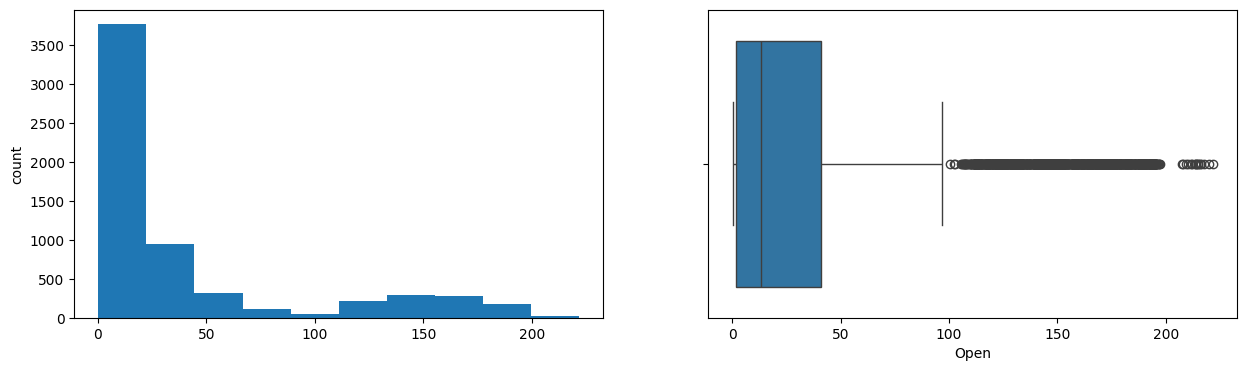

High
Skew : 1.65


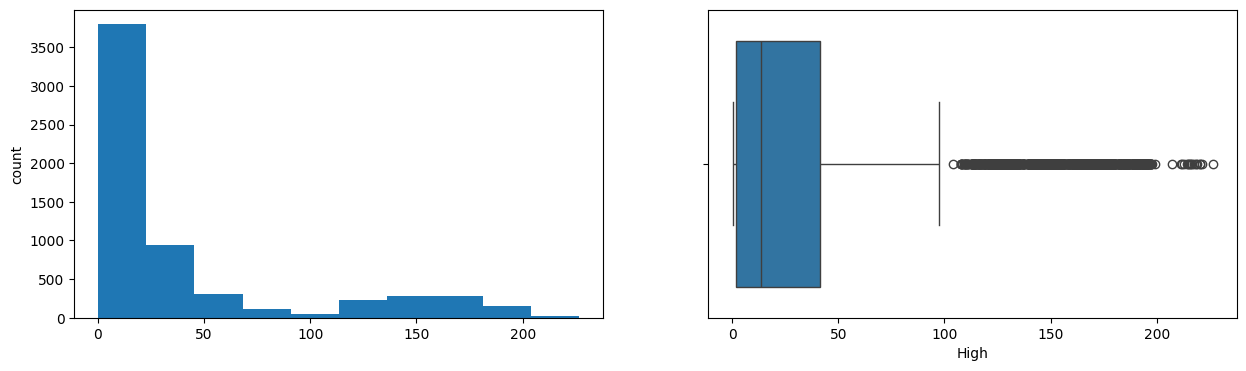

Low
Skew : 1.66


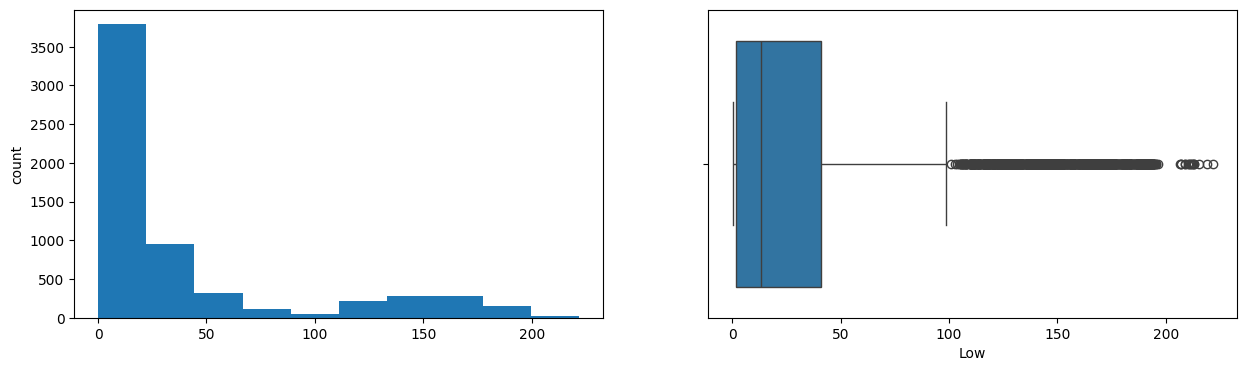

Close
Skew : 1.65


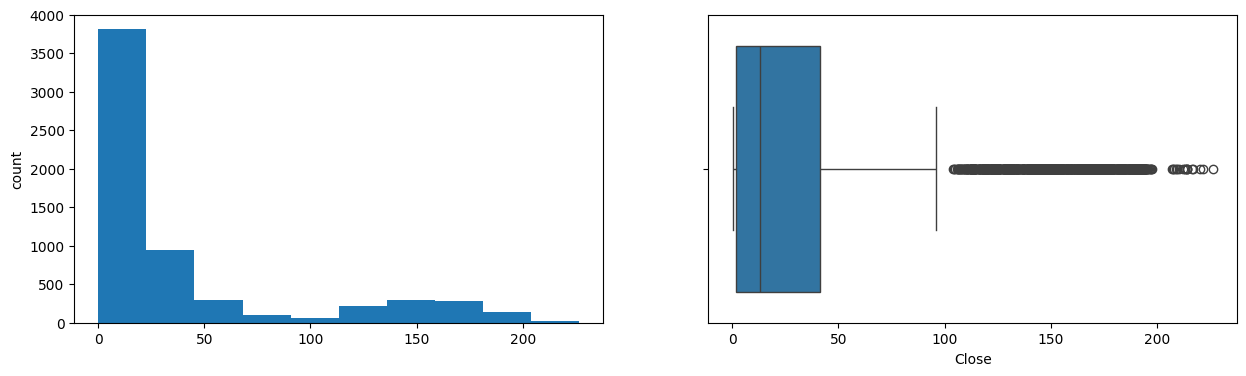

Volume
Skew : 2.97


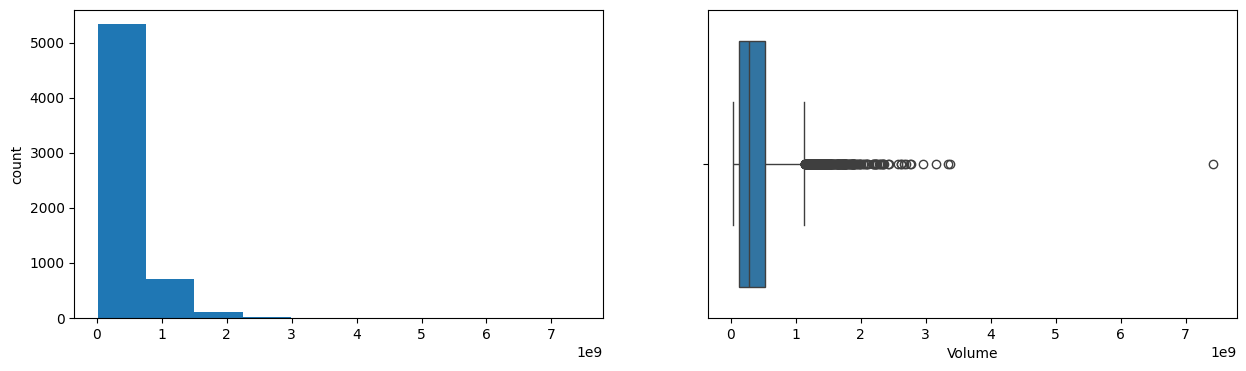

Dividends
Skew : 12.37


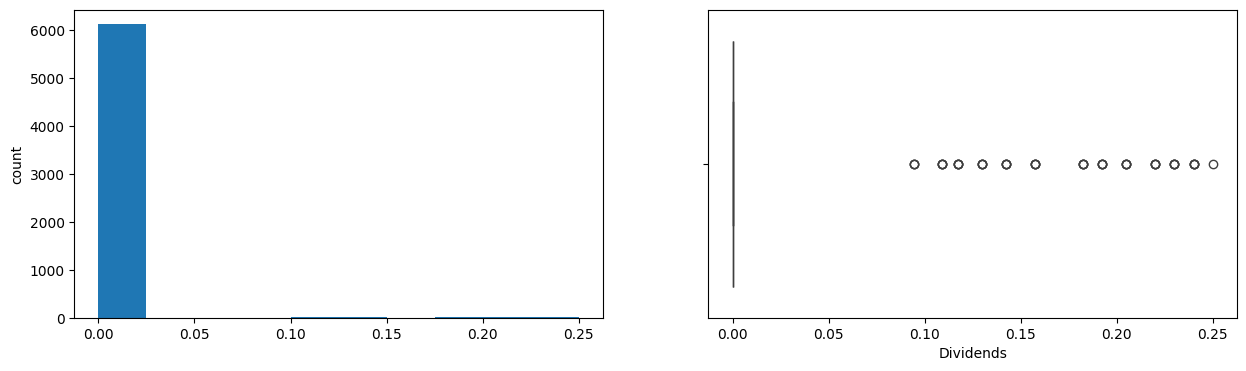

Stock Splits
Skew : 53.24


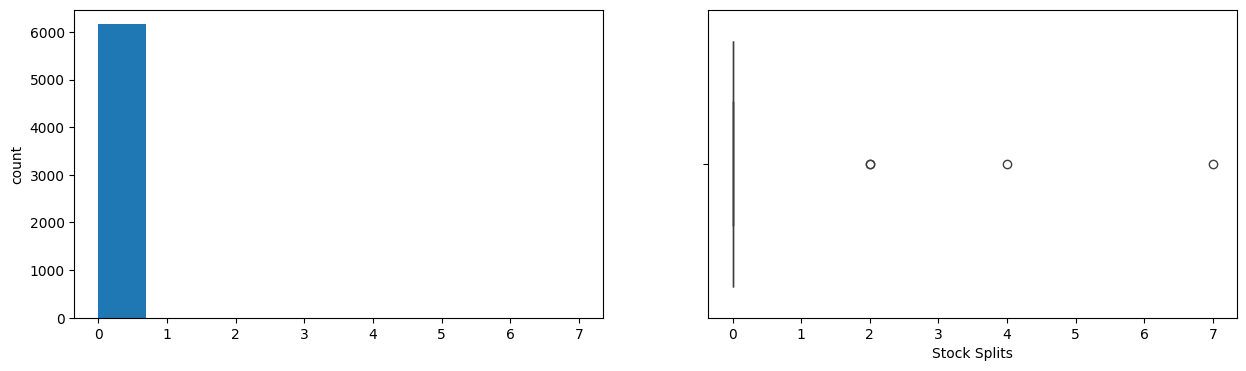

In [ ]:
import seaborn as sns

for col in num_cols:
    print(col)
    print('Skew :', round(prices_df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    prices_df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=prices_df[col])
    plt.show()


## Existe asimetria en los datos
## Los Dividendos estan altamente cesgados hacia la derecha al igual que los Stock Splits

In [ ]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6165 entries, 2000-01-03 to 2024-07-05
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6165 non-null   float64
 1   High          6165 non-null   float64
 2   Low           6165 non-null   float64
 3   Close         6165 non-null   float64
 4   Volume        6165 non-null   int64  
 5   Dividends     6165 non-null   float64
 6   Stock Splits  6165 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 514.4+ KB


# transformando datos cesgados
## aplicando una transformacion logaritmica para normalizar los datos

In [ ]:
def log_transform(data,col):
    for colname in col:
        if (data[colname] == 1.0).all():
            data[colname + '_log'] = np.log(data[colname]+1)
        else:
            data[colname + '_log'] = np.log(data[colname])
    data.info()

Text(0, 0.5, 'Precio de Cierre')

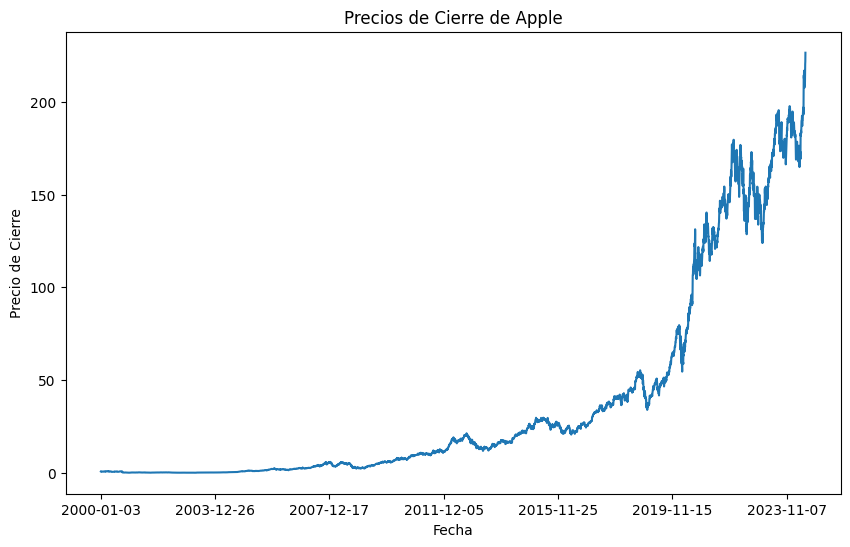

In [ ]:
# Imprimir los precios de Cierre
fig, ax = plt.subplots(figsize=(10, 6))
prices_df['Close'].plot(ax=ax)
ax.set_title('Precios de Cierre de Apple')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio de Cierre')

# Analisis Bivariable de los datos

### Utilizando un grafico de pares para ver relaciones entre las diferentes variables


#### En general la relacion entre las variables es lineal , notando no linealidades sobretodo en variables relacionadas con el volumen de las operaciones

<Figure size 1300x1700 with 0 Axes>

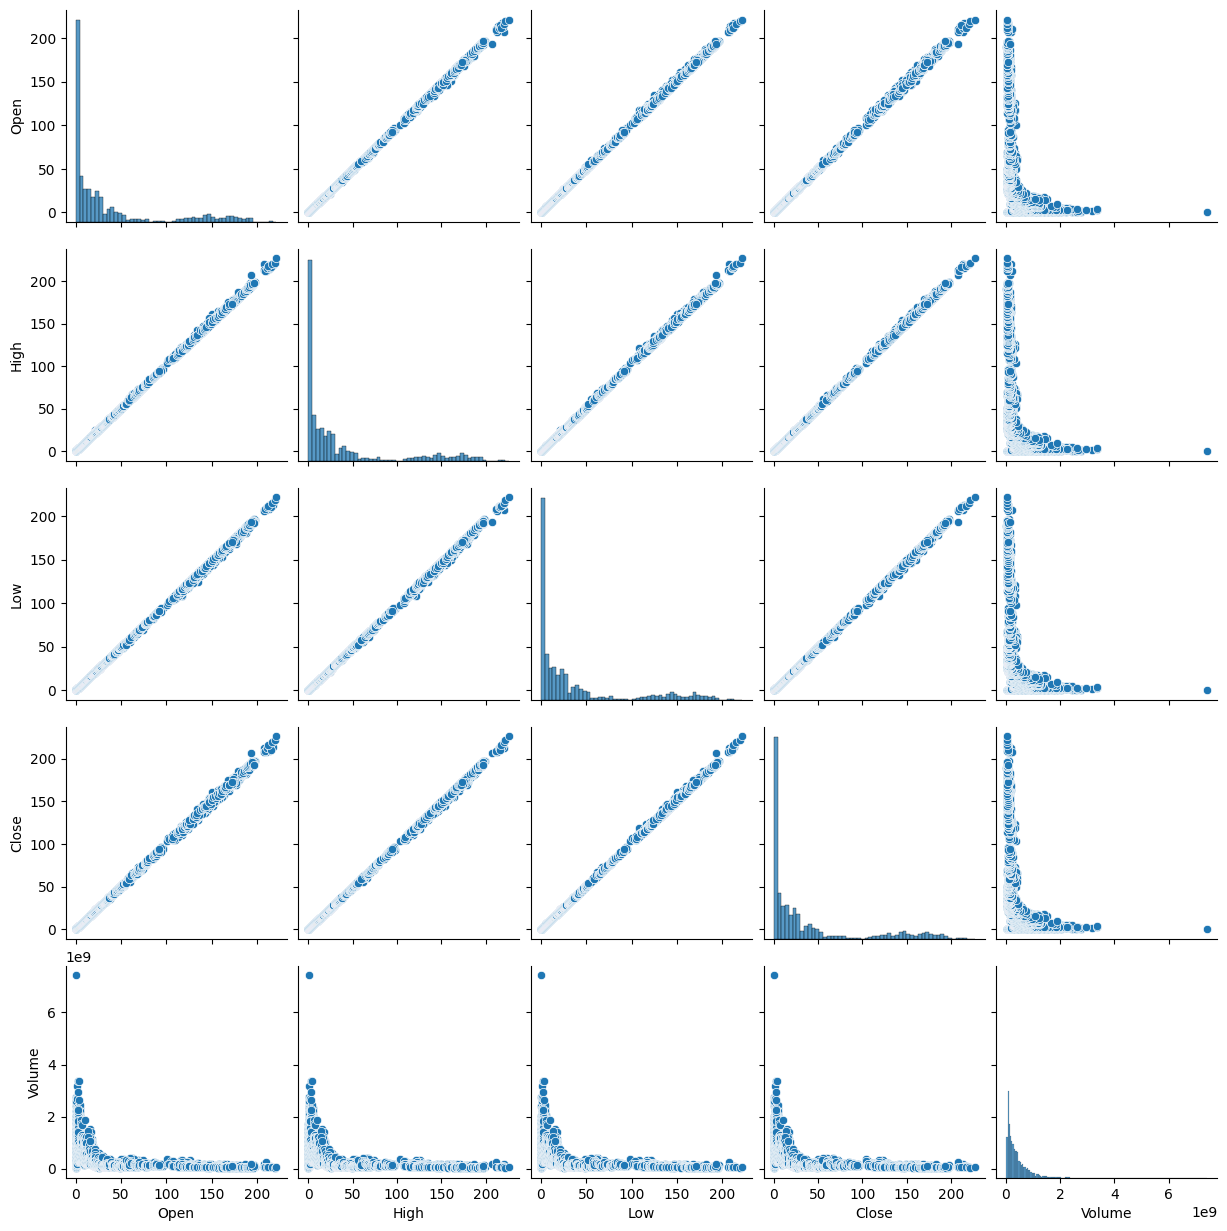

In [ ]:
plt.figure(figsize=(13,17))
sns.pairplot(data=prices_df.drop(['Dividends', 'Stock Splits'],axis=1))
plt.show()

# Analizando Correlación entre los datos usando un mapa de calor

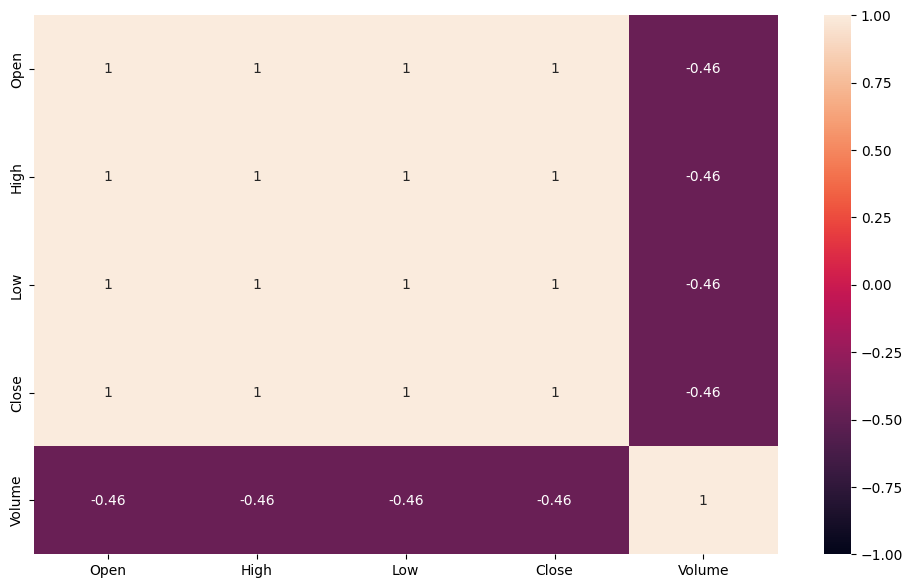

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(prices_df.drop(['Dividends','Stock Splits'],axis=1).corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

## Hay una correlación negativa entre el volumen y el resto de variables

Analizando columna: Open
Outliers usando IQR en Open:
                  Open        High         Low       Close     Volume
Date                                                                 
2020-07-31  100.479055  103.926505   98.467223  103.775131  374336800
2020-08-03  105.669758  109.026873  105.369454  106.390015  308151200
2020-08-04  106.580446  108.199186  105.852865  107.100494  173071600
2020-08-05  106.819745  107.811009  106.350966  107.488724  121776800
2020-08-06  107.823205  111.736990  107.229913  111.238914  202428800
...                ...         ...         ...         ...        ...
2024-06-28  215.770004  216.070007  210.300003  210.619995   82542700
2024-07-01  212.089996  217.509995  211.919998  216.750000   60402900
2024-07-02  216.149994  220.380005  215.100006  220.270004   58046200
2024-07-03  220.000000  221.550003  219.029999  221.550003   37369800
2024-07-05  221.649994  226.449997  221.649994  226.339996   58797569

[988 rows x 5 columns]


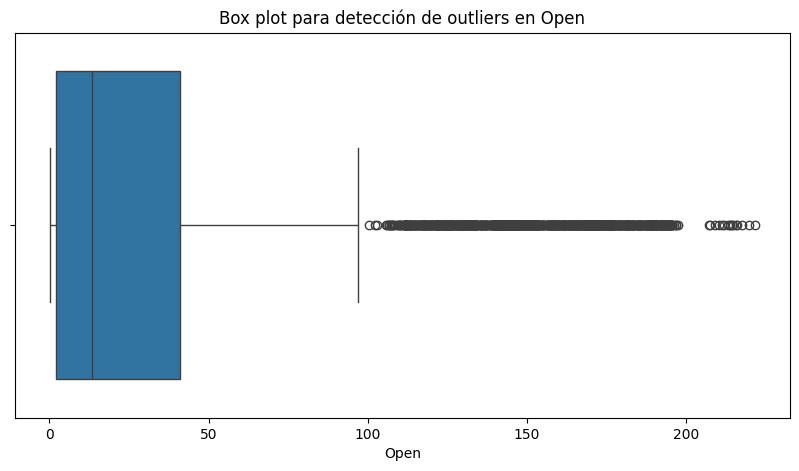

Outliers usando z-score en Open:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.100006   49772700
2024-06-28  215.770004  216.070007  210.300003  210.61999

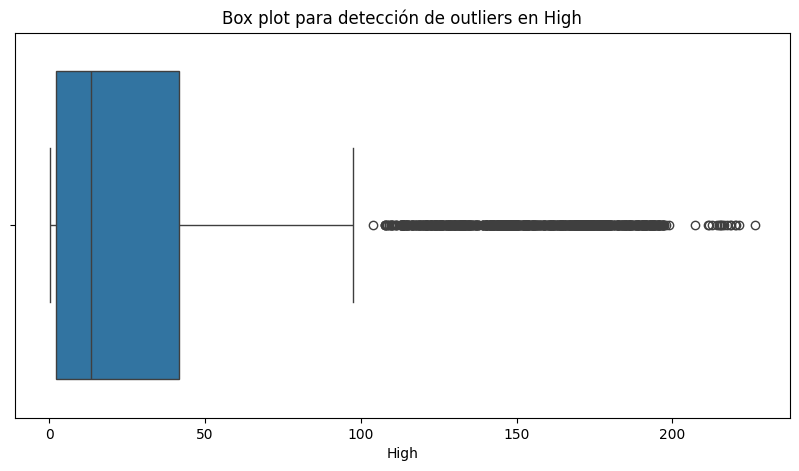

Outliers usando z-score en High:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-11  193.649994  207.160004  193.630005  207.149994  172373300
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.10000

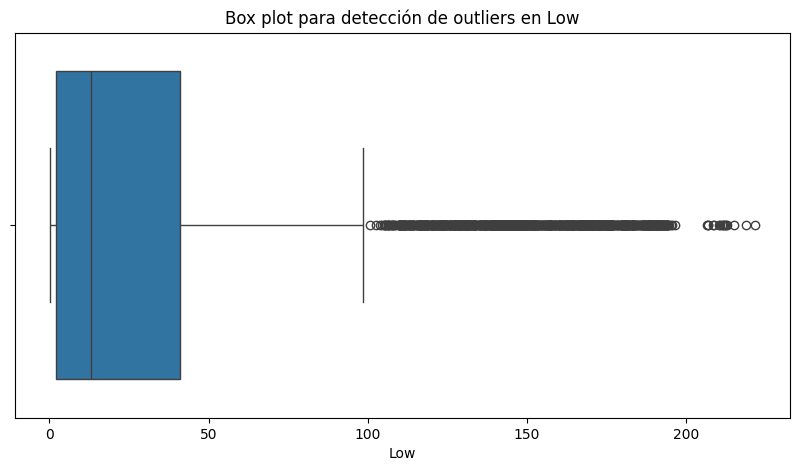

Outliers usando z-score en Low:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.100006   49772700
2024-06-28  215.770004  216.070007  210.300003  210.619995

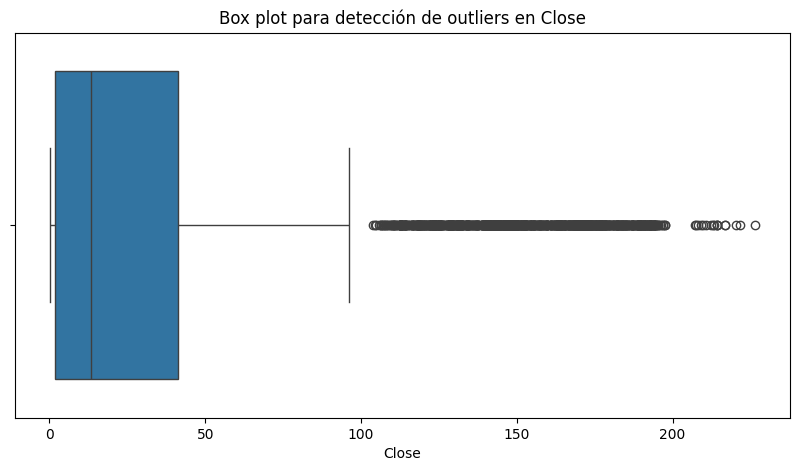

Outliers usando z-score en Close:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-11  193.649994  207.160004  193.630005  207.149994  172373300
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.1000

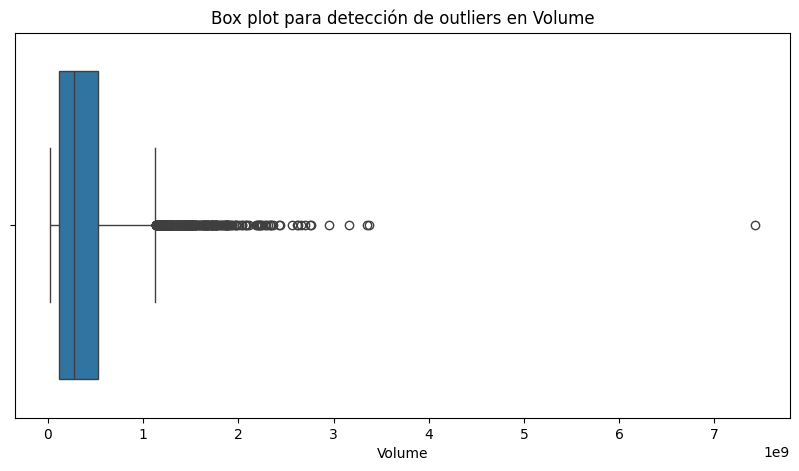

Outliers usando z-score en Volume:
                Open       High       Low      Close      Volume
Date                                                            
2000-01-20  0.871873   0.917165  0.856776   0.856776  1831132800
2000-09-29  0.425557   0.437824  0.383096   0.388757  7421640800
2000-10-02  0.402912   0.403855  0.354788   0.366112  2424788800
2000-10-03  0.376491   0.377435  0.334973   0.336861  2038120000
2001-04-19  0.385738   0.388757  0.356298   0.388305  1873670400
...              ...        ...       ...        ...         ...
2009-01-15  2.432790   2.539982  2.417089   2.517637  1831634000
2010-01-26  6.218606   6.452917  6.116850   6.218304  1867110000
2010-01-27  6.245783   6.358409  6.024757   6.276884  1722568400
2010-05-07  7.358761   7.445117  6.800157   7.121731  1676018400
2011-01-18  9.949771  10.409939  9.843485  10.285838  1880998000

[109 rows x 5 columns]
Outliers usando percentiles en Volume:
                  Open        High         Low       Clos

In [ ]:

from scipy import stats
# Excluir las columnas 'Dividends' y 'Stock Splits'
df_filtered = prices_df.drop(columns=['Dividends', 'Stock Splits'])

# Seleccionar solo las columnas numéricas
num_cols = df_filtered.select_dtypes(include=np.number).columns.tolist()

# Función para detectar outliers usando diferentes métodos
def detect_outliers(df, columns):
    for col in columns:
        print(f"Analizando columna: {col}")

        # Método del rango intercuartílico (IQR)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"Outliers usando IQR en {col}:")
        print(outliers_iqr)

        # Visualización con un diagrama de caja
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col])
        plt.title(f'Box plot para detección de outliers en {col}')
        plt.show()

        # Análisis de z-score
        z_scores = np.abs(stats.zscore(df[col]))
        outliers_zscore = df[z_scores > 3]

        print(f"Outliers usando z-score en {col}:")
        print(outliers_zscore)

        # Método de percentiles
        lower_percentile = df[col].quantile(0.01)
        upper_percentile = df[col].quantile(0.99)
        outliers_percentile = df[(df[col] < lower_percentile) | (df[col] > upper_percentile)]

        print(f"Outliers usando percentiles en {col}:")
        print(outliers_percentile)

# Detectar outliers en las columnas numéricas excluyendo 'Dividends' y 'Stock Splits'
detect_outliers(df_filtered, num_cols)

### Creación del modelo

In [ ]:
news_df

title  \
Date                                                            
2012-07-23  Summer Heat Scorches Europe And U S  Apple Ear...   
2012-07-24                             Market Bait And Switch   
2012-07-27                     Will AAPL Fall From The Tree     
2012-07-30           Bulls Snatch Victory From Jaws of Defeat   
2012-07-31  What s Driving China s Real Estate Rally   Par...   
...                                                       ...   
2020-01-21  Honda to join White House initiative to boost ...   
2020-01-22  How Services Will Become Apple s Next  100 Bil...   
2020-01-23  Broadcom  Deals with Apple could be worth  15 ...   
2020-01-24  Need to Know  Apple shares are bound for  400 ...   
2020-01-27  Apple Set To Beat Q1 Earnings Estimates  Tech ...   

                                                      content   POSITIVE  \
Date                                                                       
2012-07-23  Europe flares as summer heat continues  Summer...   1.312215   
2012-07-24  That is the sound we are going to hear soon fr...   0.057011   
2012-07-27  Apple s  AAPL  sales for the third quarter mis...   0.000834   
2012-07-30  Last week  the bulls pulled another save out o...   0.252697   
2012-07-31  In the preceding posts  I examined the first t...   1.972691   
...                                                       ...        ...   
2020-01-21  By David Shepardson\nWASHINGTON  Reuters    Ho...  15.215485   
2020-01-22  There has been no greater growth story in the ...  13.098037   
2020-01-23  Broadcom Inc  \r\n\r\n                        ...  11.316891   
2020-01-24  A week that started with a coronavirus panic l...   8.038409   
2020-01-27  Technology giant Apple   NASDAQ AAPL   is set ...   2.793224   

             NEGATIVE                                          embedding  
Date                                                                      
2012-07-23   1.687785  [0.05905736, 0.78830993, 0.06396842, 0.13975, ...  
2012-07-24   0.942989  [0.37770188, 0.25995106, 0.2782316, -0.3666865...  
2012-07-27   0.999166  [-0.34234846, 0.27494824, 0.10981934, -0.38767...  
2012-07-30   0.747303  [0.110929586, 0.7759576, 0.13119523, -0.122955...  
2012-07-31   0.027309  [0.18154113, 0.86173123, 0.20491433, -0.140338...  
...               ...                                                ...  
2020-01-21  15.784515  [-0.06789234, 0.8455888, 0.042718202, 0.025157...  
2020-01-22  16.901963  [-0.010230099, 0.8463018, 0.097570255, -0.0204...  
2020-01-23  12.683109  [-0.062053367, 1.0213993, 0.018127568, 0.06611...  
2020-01-24   7.961590  [0.17322911, 0.76700693, 0.08080406, -0.116923...  
2020-01-27   5.206776  [0.028347082, 0.9416446, 0.056148864, -0.01144...  

[1531 rows x 5 columns]

MinMaxScaler Head:
       Open      High       Low     Close    Volume
0  0.002689  0.002873  0.002599  0.002861  0.069178
1  0.002804  0.002811  0.002582  0.002546  0.066012
2  0.002651  0.002809  0.002644  0.002596  0.101962
3  0.002732  0.002690  0.002371  0.002295  0.100563
4  0.002404  0.002490  0.002388  0.002445  0.059031
MinMaxScaler Skew:
Open      1.654599
High      1.652611
Low       1.657409
Close     1.654882
Volume    2.969103
dtype: float64

StandardScaler Head:
       Open      High       Low     Close    Volume
0 -0.673803 -0.672878 -0.673852 -0.672678  0.372172
1 -0.673336 -0.673134 -0.673922 -0.673982  0.311264
2 -0.673959 -0.673143 -0.673669 -0.673775  1.002914
3 -0.673630 -0.673630 -0.674786 -0.675018  0.976000
4 -0.674961 -0.674451 -0.674717 -0.674396  0.176954
StandardScaler Skew:
Open      1.654599
High      1.652611
Low       1.657409
Close     1.654882
Volume    2.969103
dtype: float64

Log Transformation Head:
                Open      High       Low     Clos

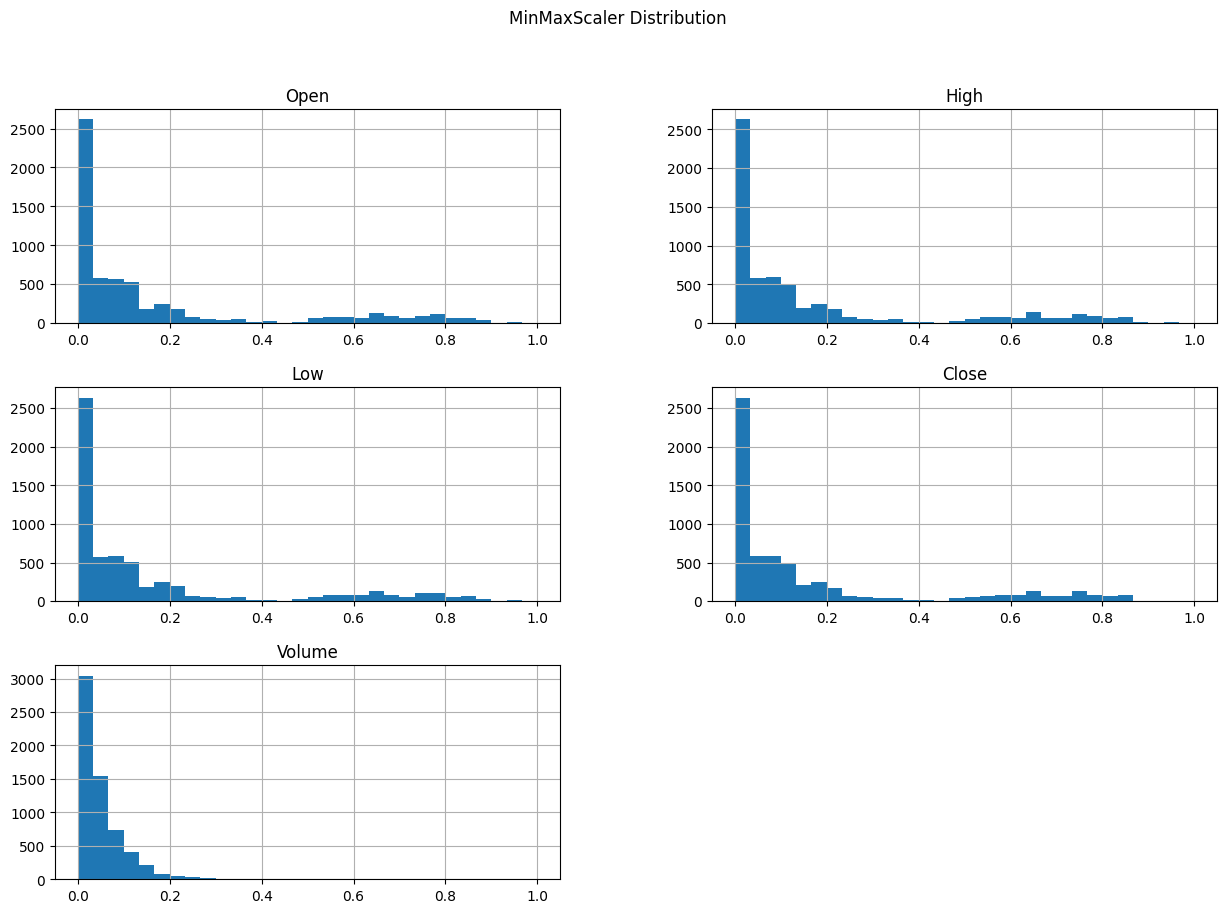

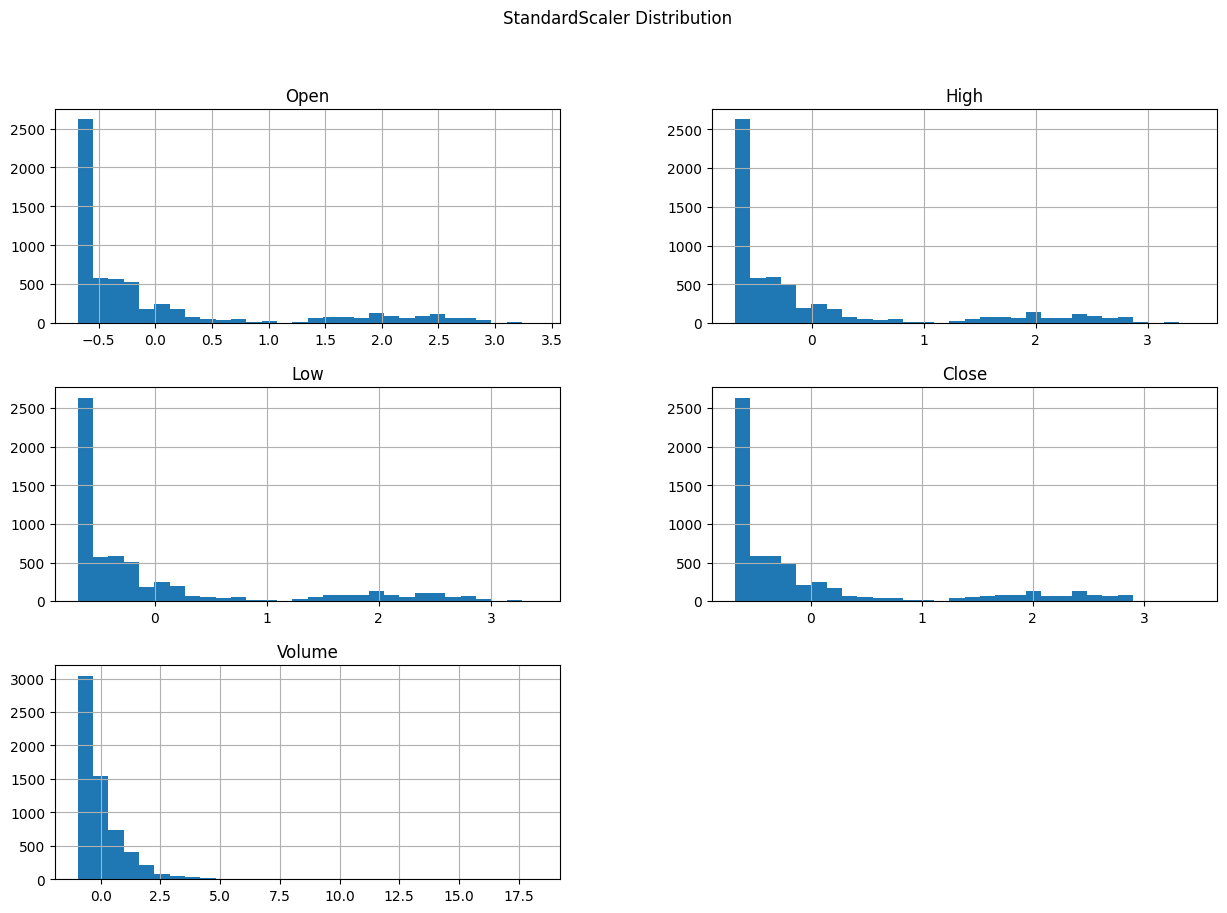

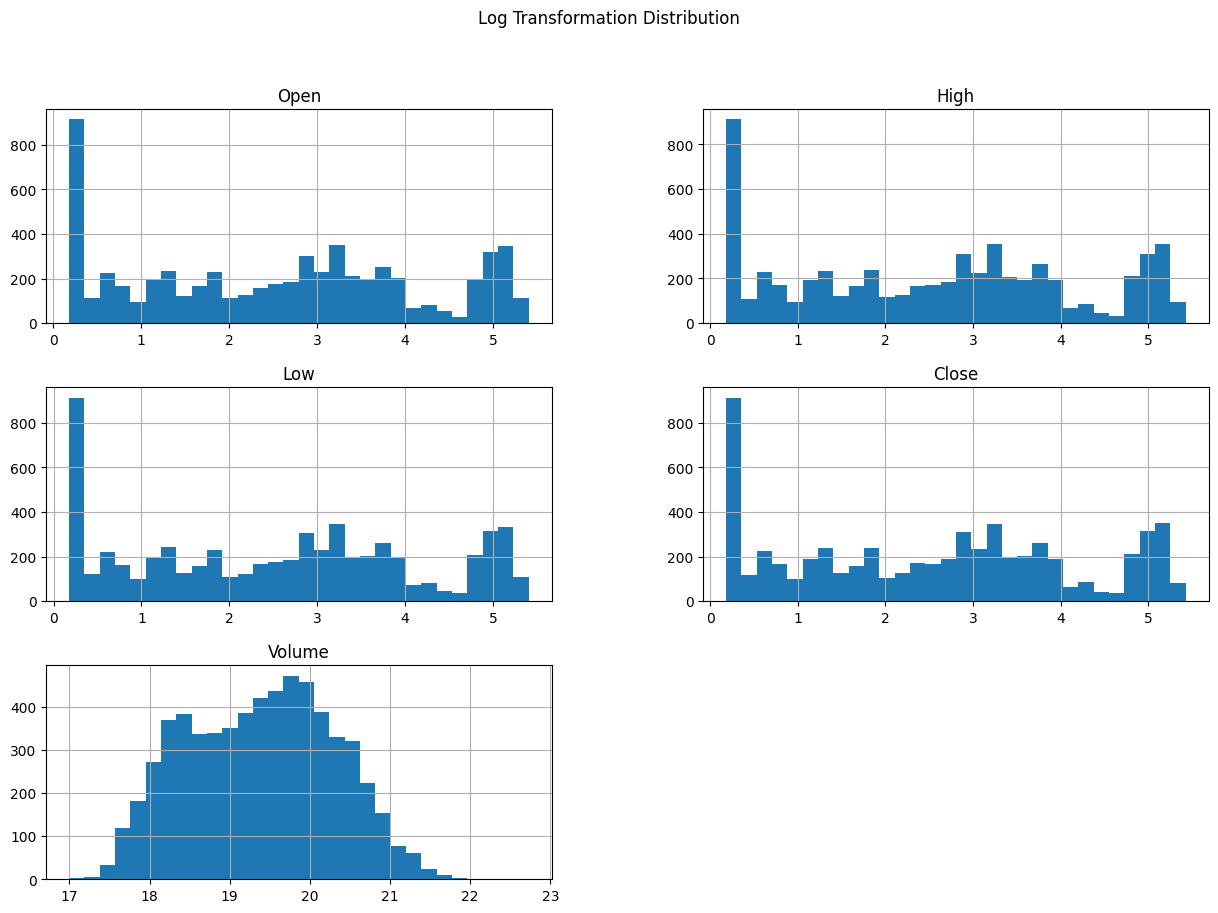

In [ ]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Supongamos que prices_df ya está definido
# prices_df = ...

# Excluir las columnas 'Dividends' y 'Stock Splits'
columns_to_exclude = ['Dividends', 'Stock Splits']
prices_df_excluded = prices_df.drop(columns=columns_to_exclude)

# Normalización utilizando MinMaxScaler
min_max_scaler = MinMaxScaler()
prices_min_max = min_max_scaler.fit_transform(prices_df_excluded)
prices_min_max_df = pd.DataFrame(prices_min_max, columns=prices_df_excluded.columns)

# Normalización utilizando StandardScaler
standard_scaler = StandardScaler()
prices_standard = standard_scaler.fit_transform(prices_df_excluded)
prices_standard_df = pd.DataFrame(prices_standard, columns=prices_df_excluded.columns)

# Transformación logarítmica
prices_log = np.log1p(prices_df_excluded)  # np.log1p es equivalente a np.log(1 + x)
prices_log_df = pd.DataFrame(prices_log, columns=prices_df_excluded.columns)

# Función para calcular el skew de cada columna
def calculate_skew(df):
    return df.skew()

# Mostrar el head del DataFrame y el skew para cada normalización
print("MinMaxScaler Head:")
print(prices_min_max_df.head())
print("MinMaxScaler Skew:")
print(calculate_skew(prices_min_max_df))

print("\nStandardScaler Head:")
print(prices_standard_df.head())
print("StandardScaler Skew:")
print(calculate_skew(prices_standard_df))

print("\nLog Transformation Head:")
print(prices_log_df.head())
print("Log Transformation Skew:")
print(calculate_skew(prices_log_df))

# Graficar la distribución de los datos normalizados
def plot_distribution(df, title):
    df.hist(bins=30, figsize=(15, 10))
    plt.suptitle(title)
    plt.show()

plot_distribution(prices_min_max_df, "MinMaxScaler Distribution")
plot_distribution(prices_standard_df, "StandardScaler Distribution")
plot_distribution(prices_log_df, "Log Transformation Distribution")

